In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import date, datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings


warnings.filterwarnings('ignore')
np.random.seed(4123)

skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=123)


/Users/irochka/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [18]:
df_train = pd.read_csv('../Elo Merchant/train.csv')
df_test = pd.read_csv('../Elo Merchant/test.csv')
df_hist_trans = pd.read_csv('../Elo Merchant/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../Elo Merchant/new_merchant_transactions.csv')

In [19]:
df_train.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749
5,2016-09,C_ID_0894217f2f,4,2,0,0.871585
6,2016-12,C_ID_7e63323c00,3,2,1,0.230129
7,2017-09,C_ID_dfa21fc124,3,2,1,2.135850
8,2017-08,C_ID_fe0fdac8ea,2,1,0,-0.065406
9,2016-08,C_ID_bf62c0b49d,2,2,0,0.300062


In [20]:
df_test.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1
5,2017-07,C_ID_5814b4f13c,5,1,1
6,2017-10,C_ID_a1b3c75277,1,2,0
7,2017-02,C_ID_f7cada36d3,3,1,1
8,2017-07,C_ID_9d2bc8dfc4,4,3,0
9,2016-03,C_ID_6d8dba8475,5,1,1


In [21]:
df_hist_trans.head(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05,1.0,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51,1.0,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55,1.0,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56,1.0,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22,1.0,16,37


In [22]:
df_new_merchant_trans.head(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
5,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,1.0,9,16
6,Y,C_ID_ef55cf8d4b,69,N,1,B,333,M_ID_6d061b5ddc,1,5.263697,2018-03-28 19:50:19,1.0,9,10
7,Y,C_ID_ef55cf8d4b,231,N,1,B,307,M_ID_df1e022f41,2,-0.553787,2018-04-05 08:06:52,1.0,9,19
8,Y,C_ID_ef55cf8d4b,69,N,1,B,278,M_ID_d15eae0468,2,-0.596643,2018-04-07 18:37:40,1.0,9,37
9,Y,C_ID_ef55cf8d4b,69,N,1,B,437,M_ID_5f9bffd028,1,-0.607191,2018-03-17 18:10:41,1.0,9,15


In [23]:
print(df_new_merchant_trans['category_3'].unique())

['B' nan 'C' 'A']


In [24]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [25]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)
gc.collect()

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


28

In [26]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [27]:
max_date=df_new_merchant_trans['purchase_date'].max()
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [33]:
df_hist_trans = pd.get_dummies(df_hist_trans, columns=['category_2','category_3']) 
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,weekofyear,month,dayofweek,weekend,hour,month_diff,category_2_0,category_2_1,category_3_0,category_3_1
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,...,25,6,6,1,15,13,0,1,0,1
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,...,28,7,5,1,12,13,0,1,0,1
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,...,32,8,2,0,22,14,0,1,0,1
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,...,35,9,5,1,10,14,0,1,0,1
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,...,10,3,4,0,1,14,0,1,0,1


In [34]:
df_new_merchant_trans = pd.get_dummies(df_new_merchant_trans, columns=['category_2','category_3']) 
df_new_merchant_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,hour,month_diff,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,...,14,13,1,0,0,0,0,0,1,0
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,...,18,13,1,0,0,0,0,0,1,0
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,...,14,13,1,0,0,0,0,0,1,0
3,1,C_ID_415bb3a509,-1,1,1,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,...,9,14,0,0,0,0,0,0,1,0
4,1,C_ID_ef55cf8d4b,-1,1,1,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,...,21,13,0,0,0,0,0,0,1,0


In [36]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

#for col in ['category_2','category_3']:
 #   df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
 #   aggs[col+'_mean'] = ['mean']    
    
new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group
gc.collect()

147

In [37]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

#for col in ['category_2','category_3']:
 #   df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
 #   aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

154

In [38]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,9,23,35,7,...,0.260870,13.347826,6.0,0.260870,0.0,0.000000,23.0,54.0,2.347826,340.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,12,24,50,7,...,0.300000,14.500000,0.0,0.000000,0.0,0.000000,6.0,56.0,9.333333,371.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,10,14,22,7,...,NaN,13.000000,1.0,1.000000,0.0,0.000000,1.0,0.0,0.000000,341.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,6,16,20,7,...,0.238095,13.428571,3.0,0.428571,1.0,0.142857,7.0,41.0,5.857143,351.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,4,22,17,7,...,0.253968,13.277778,12.0,0.333333,2.0,0.055556,36.0,57.0,1.583333,341.0
5,2016-09,C_ID_0894217f2f,4,2,0,0.871582,7,13,16,6,...,0.250000,20.250000,0.0,0.000000,0.0,0.000000,4.0,31.0,7.750000,566.0
6,2016-12,C_ID_7e63323c00,3,2,1,0.230103,12,16,48,7,...,0.200000,13.600000,0.0,0.000000,0.0,0.000000,5.0,31.0,6.200000,363.0
7,2017-09,C_ID_dfa21fc124,3,2,1,2.136719,4,9,8,7,...,0.000000,15.333333,2.0,0.666667,0.0,0.000000,3.0,12.0,4.000000,410.0
8,2017-08,C_ID_fe0fdac8ea,2,1,0,-0.065430,5,8,6,5,...,0.000000,13.000000,1.0,0.500000,0.0,0.000000,2.0,3.0,1.500000,380.0
9,2016-08,C_ID_bf62c0b49d,2,2,0,0.300049,12,14,33,7,...,0.000000,14.000000,3.0,1.000000,0.0,0.000000,3.0,7.0,2.333333,361.0


In [39]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [40]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [41]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [42]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 123}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66788	valid_1's rmse: 3.7127
[200]	training's rmse: 3.5917	valid_1's rmse: 3.6845
[300]	training's rmse: 3.54519	valid_1's rmse: 3.67451
[400]	training's rmse: 3.50901	valid_1's rmse: 3.66879
[500]	training's rmse: 3.47988	valid_1's rmse: 3.66553
[600]	training's rmse: 3.4556	valid_1's rmse: 3.66356
[700]	training's rmse: 3.43334	valid_1's rmse: 3.66246
[800]	training's rmse: 3.41226	valid_1's rmse: 3.6624
[900]	training's rmse: 3.39336	valid_1's rmse: 3.66194
Early stopping, best iteration is:
[846]	training's rmse: 3.4035	valid_1's rmse: 3.66173
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66279	valid_1's rmse: 3.72532
[200]	training's rmse: 3.58503	valid_1's rmse: 3.69781
[300]	training's rmse: 3.53795	valid_1's rmse: 3.68782
[400]	training's rmse: 3.50215	valid_1's rmse: 3.68069
[500]	training's rmse: 3.47361	valid_1's rmse: 3.67625
[600]	

3.654701440538875

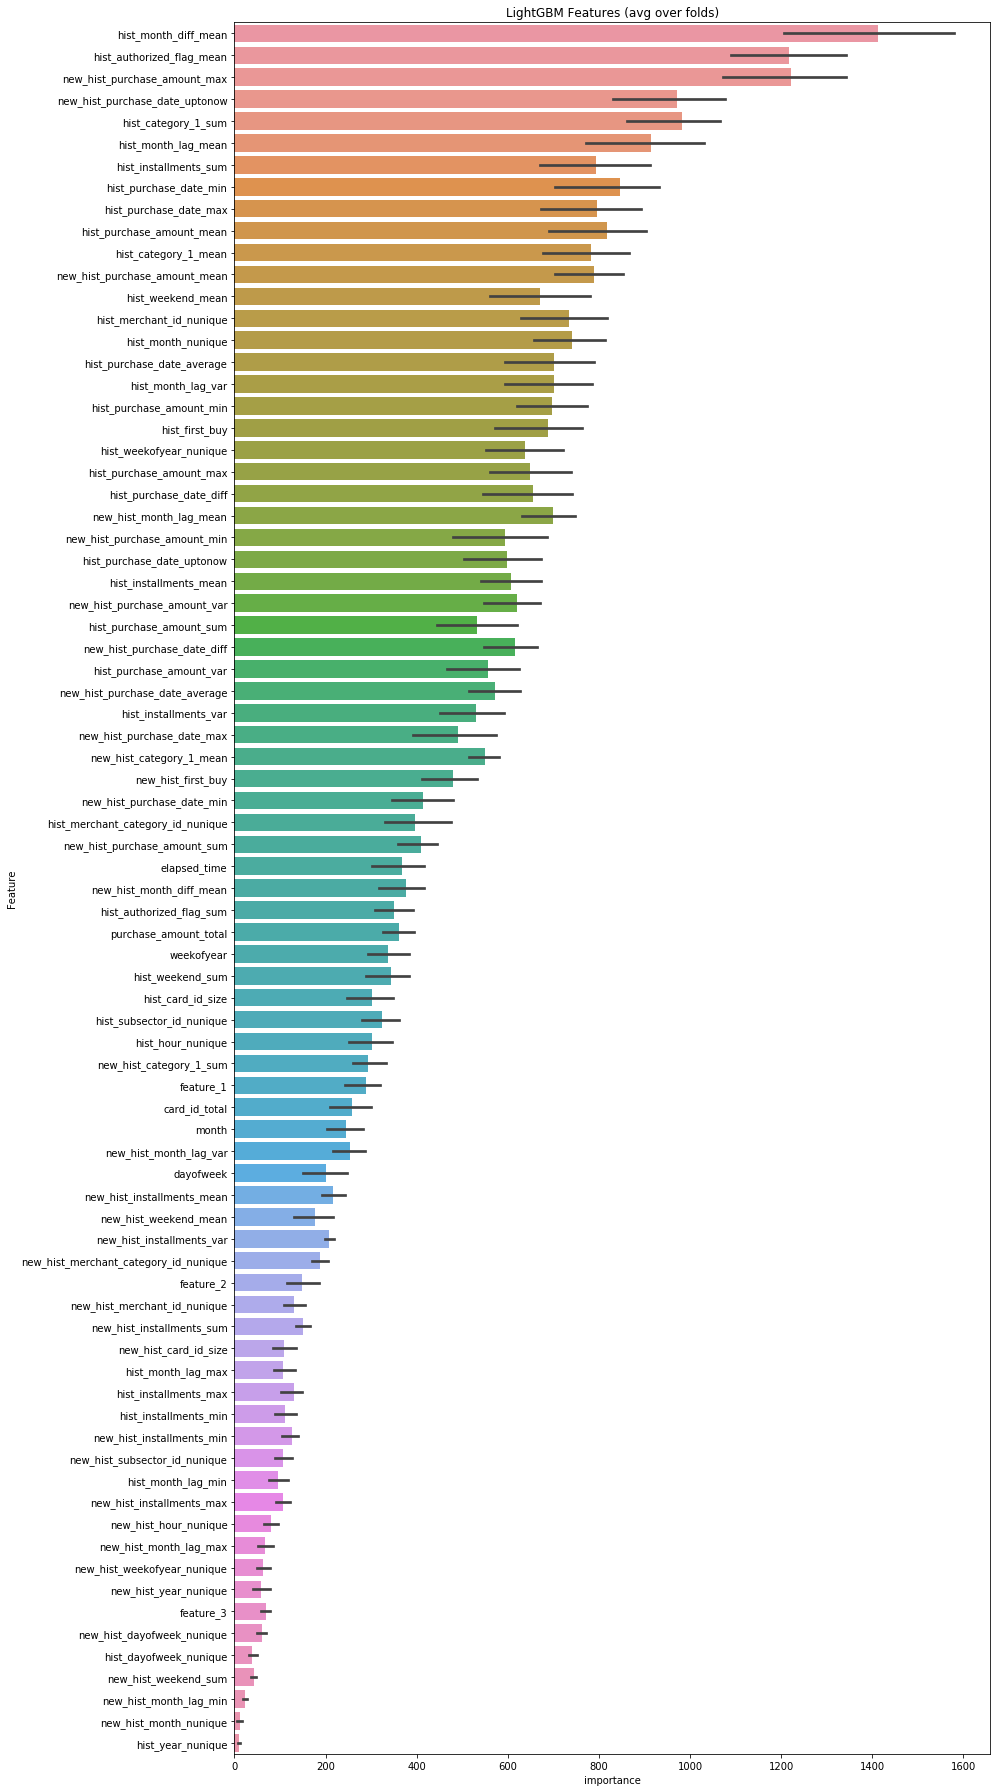

In [43]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [44]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_1.csv", index=False)

In [45]:
!kaggle competitions submit -c elo-merchant-category-recommendation -f submission_1.csv -m "with dummies"

/bin/sh: kaggle: command not found


In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 86 columns):
first_active_month                       201917 non-null datetime64[ns]
card_id                                  201917 non-null object
feature_1                                201917 non-null float64
feature_2                                201917 non-null float64
feature_3                                201917 non-null float64
hist_month_nunique                       201917 non-null int64
hist_hour_nunique                        201917 non-null int64
hist_weekofyear_nunique                  201917 non-null int64
hist_dayofweek_nunique                   201917 non-null int64
hist_year_nunique                        201917 non-null int64
hist_subsector_id_nunique                201917 non-null int64
hist_merchant_id_nunique                 201917 non-null int64
hist_merchant_category_id_nunique        201917 non-null int64
hist_purchase_amount_sum                 201917 non-nu